<a href="https://colab.research.google.com/github/harshitadd/Celestini/blob/master/Generalised_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install firebase-admin
import os 
import math
import cv2
import numpy as np 
import csv
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 

In [0]:
#Get Images from Firebase Storage
import datetime
import firebase_admin
from firebase_admin import credentials
from firebase_admin import storage

# Fetch the service account key JSON file contents
cred = credentials.Certificate("credentials.json")

# Initialize the app with a service account, granting admin privileges
app = firebase_admin.initialize_app(cred, {
    'storageBucket': 'fir-4ca2c.appspot.com',
}, name='storage')

In [0]:
def transmission(img, lt = 230, retMean = False):
  ker = np.ones((3, 3))/9.0
  imgrgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  b, g, r = cv2.split(img)
  hsv = cv2.cvtColor(imgrgb, cv2.COLOR_RGB2HSV)
  _, _, v = cv2.split(hsv)
  v_blur = cv2.filter2D(v, -1, ker)
  _,building_mask = cv2.threshold(v_blur, lt, 255, cv2.THRESH_BINARY)
  sky = cv2.bitwise_and(imgrgb, imgrgb, mask = building_mask)
  sky_mask = cv2.bitwise_not(building_mask, building_mask.copy())
  building = cv2.bitwise_and(imgrgb, imgrgb, mask = sky_mask)
 
  al = max(v_blur.flatten())
  #Airlight Found. Now calculate Transmission Map
  img_norm = img/float(al)
  b, g, r = cv2.split(img_norm)
  kernel = np.ones((3,3),np.uint8)
  im_new = np.zeros((img.shape[0], img.shape[1]))
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      im_new[i][j] = min(b[i][j], g[i][j], r[i][j])
  dcp = cv2.erode(im_new, kernel, iterations = 1)
  #ax[3].imshow(im_new, cmap = 'gray')
  #ax[4].imshow(dcp, cmap = 'gray')
  tr = np.ones((dcp.shape[0], dcp.shape[1]))
  for i in range(dcp.shape[0]):
    for j in range(dcp.shape[1]):
      tr[i][j] = 1 - dcp[i][j]
  #ax[1].imshow(tr, cmap = 'gray')
  if retMean == False:
    return tr
  elif retMean == True:
    return np.mean(tr)

In [0]:
def entropy(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  hist = cv2.calcHist( [image.astype('float32')],
              [0], 
              None,
               [256], 
              [0,256] )
  h_norm = 0
  h_norm = cv2.normalize(hist, h_norm)
  ent = 0
  for p in h_norm:
    try:
      ent += p*math.log(p, 2)
    except:
      pass
    
  return (-1 * ent[0])

In [0]:
def contrast(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  s = 0
  ss = 0
  mean = np.mean(image)
  x = (-1 * mean * (np.ones(image.shape)))
  ss = np.square(np.add(image, x))
  cont = np.sqrt(np.sum(ss)/float(image.size))
  return cont

In [0]:
#Loading E1 - Lenovo data : 504 -- sscb labels 

data = []
reading = []
t = 0
bucket = storage.bucket(app=app)
blobs = bucket.list_blobs()

imglenovo = []

mits = set()
for blob in blobs:
  if blob.name[7:16]=="lenovoinS" :
    if int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5:
      blob.download_to_filename('/content/' + "lenovo" + str(blob.name.split('/')[-1])+ '.jpeg')
      imglenovo.append("lenovo" + str(blob.name.split('/')[-1])+ '.jpeg') 
      print("lenovo" + str(blob.name.split('/')[-1])+ '.jpeg')



In [0]:
##Loading E2 - Mi data : 760 -- sscb labels 

bucket = storage.bucket(app=app)
blobs = bucket.list_blobs()

imgminote = []

mits = set()
for blob in blobs:
  if blob.name[7:16]=="minoteSSC" :
    if int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5:
        print(blob.name)

        blob.download_to_filename('/content/' + "minote" + str(blob.name.split('/')[-1])+ '.jpeg')
        imgminote.append("minote" + str(blob.name.split('/')[-1])+ '.jpeg') 
        print("minote" + str(blob.name.split('/')[-1])+ '.jpeg')


In [16]:
im_trans=[]
im_ent=[]
im_cont=[]

for img in imgminote:
  im = cv2.imread(img)
  im = cv2.resize(im, (32,32))
  im_trans.append(transmission(im, retMean = True))
  im_ent.append(entropy(im))
  im_cont.append(contrast(im))
  k+=1
  print(k)
  
  
print(len(im_trans))
print(len(im_ent))
print(len(im_cont))


for img in imglenovo:
  im = cv2.imread(img)
  im = cv2.resize(im, (32,32))
  im_trans.append(transmission(im, retMean = True))
  im_ent.append(entropy(im))
  im_cont.append(contrast(im))
  k+=1
  print(k)

print(len(im_trans))
print(len(im_ent))
print(len(im_cont))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [0]:
dict={}
for i in range(0,505):
  l=[]
  l.append(im_trans[i])
  l.append(im_ent[i])
  l.append(im_cont[i])
  dict[(imglenovo[i])]=l

In [0]:
k=0
for i in range(506,1330):
  l=[]
  l.append(im_trans[i])
  l.append(im_ent[i])
  l.append(im_cont[i])
  dict[(imgminote[k])]=l
  k+=1
  

In [0]:
# With flattened transmission
# for img in imgminote:
#   im = cv2.imread(img)
#   im = cv2.resize(im, (32,32))
#   im_trans.append(np.ndarray.flatten(transmission(im, retMean = False)))
#   im_ent.append(entropy(im))
#   im_cont.append(contrast(im))
#   k+=1

# With transmission mean 


In [111]:
print(im_trans)
print(im_ent)
print(im_cont)

[0.8213759600105932, 0.8054319646860987, 0.906191697761194, 0.7759951636904763, 0.759033203125, 0.7889368840767637, 0.771240234375, 0.6446902252906976, 0.7489304315476191, 0.73984375, 0.6258055515552995, 0.7317693929756637, 0.7510230654761905, 0.7766362847222221, 0.6625560538116593, 0.6624568904842343, 0.7558720576298702, 0.6601118607954546, 0.755755974264706, 0.6711414734162896, 0.6672309027777779, 0.6654058064956332, 0.6728515625, 0.6689410480349345, 0.6663298233695653, 0.6667107328056768, 0.6712873714826839, 0.6725091314935066, 0.6763032058189655, 0.6743038862179487, 0.6719844423491379, 0.6737565665409483, 0.6758525013412018, 0.6727416463744589, 0.6747331290409483, 0.6691778273809523, 0.6708100417564655, 0.674695714860515, 0.6654810412176725, 0.767670036764706, 0.762771905637255, 0.7669883578431373, 0.7636335784313726, 0.7619293811274511, 0.7625382965686276, 0.7725643382352942, 0.7672257965686275, 0.76812193627451, 0.7661573223039218, 0.7446959252450982, 0.7624004289215687, 0.760003

In [0]:
k=0
for key in dict:
  k+=1
  if(k==505):
    print(key[:-5])
    print(dict[key])
  if(k==506):
    print(key)
    print(dict[key])
 

In [21]:
#converting all image timestamps into cpcb compatible timestamp 
tmp=[]
for key in dict:
  temp=key[-24:-5]
  temp=temp.split('-')
  
  newtemp=temp[2].split(' ')
  
  newesttemp=newtemp[1].split(':')
  j=int(newesttemp[1])
  #print(j)
  if(j<=7.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  elif(j<=15 or j<=22.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '15'
  elif(j<=30 or j<=37.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '30'
  elif(j<=45 or j<=52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '45'
  elif(j>52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  tmp.append(final)
  
  
print(tmp)

['27-06-2019 17:00', '27-06-2019 17:00', '27-06-2019 17:15', '27-06-2019 17:15', '27-06-2019 18:00', '27-06-2019 18:15', '27-06-2019 18:15', '27-06-2019 18:15', '27-06-2019 18:30', '27-06-2019 18:30', '27-06-2019 18:30', '27-06-2019 18:45', '27-06-2019 18:45', '27-06-2019 18:45', '27-06-2019 18:00', '28-06-2019 06:00', '28-06-2019 06:00', '28-06-2019 06:15', '28-06-2019 06:15', '28-06-2019 06:15', '28-06-2019 06:30', '28-06-2019 06:30', '28-06-2019 06:30', '28-06-2019 06:45', '28-06-2019 06:45', '28-06-2019 06:45', '28-06-2019 06:00', '28-06-2019 07:00', '28-06-2019 07:00', '28-06-2019 07:15', '28-06-2019 07:15', '28-06-2019 07:15', '28-06-2019 07:30', '28-06-2019 07:30', '28-06-2019 07:30', '28-06-2019 07:45', '28-06-2019 07:45', '28-06-2019 07:45', '28-06-2019 07:00', '28-06-2019 08:00', '28-06-2019 08:00', '28-06-2019 08:15', '28-06-2019 08:15', '28-06-2019 08:15', '28-06-2019 08:30', '28-06-2019 08:30', '28-06-2019 08:30', '28-06-2019 08:45', '28-06-2019 08:45', '28-06-2019 08:45',

In [0]:
i=0
ecttime=[]
for key in dict:
  l=[]
  l.append(tmp[i])
  l.append(dict[key])
  ecttime.append(l)
  i+=1

##ecttime is the list with modified timestamp matched with e,c,t(flattened transmission)

In [112]:
print(ecttime)

[['27-06-2019 17:00', [0.8213759600105932, 42.08242416381836, 56.565832682688196]], ['27-06-2019 17:00', [0.8054319646860987, 41.52888107299805, 51.499371830340586]], ['27-06-2019 17:15', [0.906191697761194, 23.427310943603516, 22.633249960040253]], ['27-06-2019 17:15', [0.7759951636904763, 5.428897857666016, 2.7180139707272217]], ['27-06-2019 18:00', [0.759033203125, 5.230010032653809, 2.6006590961475515]], ['27-06-2019 18:15', [0.7889368840767637, 29.528430938720703, 38.687402136560266]], ['27-06-2019 18:15', [0.771240234375, 5.240905284881592, 2.5989893196006864]], ['27-06-2019 18:15', [0.6446902252906976, 39.1527214050293, 60.97394543150685]], ['27-06-2019 18:30', [0.7489304315476191, 5.268103122711182, 2.5575765436824045]], ['27-06-2019 18:30', [0.73984375, 5.268465042114258, 2.5652071911152925]], ['27-06-2019 18:30', [0.6258055515552995, 39.8203239440918, 62.1486148201111]], ['27-06-2019 18:45', [0.7317693929756637, 41.28462219238281, 57.25363733988838]], ['27-06-2019 18:45', [0.

In [124]:
#TEMPORARY FIX - REPLACED ALL NONE BY 0.0 - 153 Reading 
k=0
cpcb=[]
with open('/content/sscb_labels_27_2.csv') as file:
  reader = csv.reader(file, delimiter =',')
  for row in reader:
    k+=1
    if(k>=18):
      l=[]
      l.append(row[0])
      l.append(row[2])
      cpcb.append(l)      
      
print(len(cpcb))
print(cpcb)


466
[['27-06-2019 18:00', '36'], ['27-06-2019 18:15', '36'], ['27-06-2019 18:30', '36'], ['27-06-2019 18:45', '36'], ['27-06-2019 19:00', '42'], ['27-06-2019 19:15', '42'], ['27-06-2019 19:30', '42'], ['27-06-2019 19:45', '42'], ['27-06-2019 20:00', '59'], ['27-06-2019 20:15', '59'], ['27-06-2019 20:30', '59'], ['27-06-2019 20:45', '59'], ['27-06-2019 21:00', '74'], ['27-06-2019 21:15', '74'], ['27-06-2019 21:30', '74'], ['27-06-2019 21:45', '74'], ['27-06-2019 22:00', '59'], ['27-06-2019 22:15', '59'], ['27-06-2019 22:30', '59'], ['27-06-2019 22:45', '59'], ['27-06-2019 23:00', '67'], ['27-06-2019 23:15', '67'], ['27-06-2019 23:30', '67'], ['27-06-2019 23:45', '67'], ['28-06-2019 00:00', '85'], ['28-06-2019 00:15', '85'], ['28-06-2019 00:30', '85'], ['28-06-2019 00:45', '85'], ['28-06-2019 01:00', '94'], ['28-06-2019 01:15', '94'], ['28-06-2019 01:30', '94'], ['28-06-2019 01:45', '94'], ['28-06-2019 02:00', '117'], ['28-06-2019 02:15', '117'], ['28-06-2019 02:30', '117'], ['28-06-2019

In [0]:
for e in cpcb:
  if(e[1]=='None'):
    print(e)

In [25]:
print(ecttime[0][1])

[0.8213759600105932, 42.08242416381836, 56.565832682688196]


In [0]:
final=[]
for e in ecttime:
  for tmp in cpcb:
    if(tmp[0] == e[0]):
      l=[]
      l.append(tmp[0])
      l.append(tmp[1])
      l.append(e[1])
      final.append(l)


In [117]:
print(len(final))

1239


In [126]:
#the entropy and contrast are drastically different - 6 pm 
print(final[0])
print(im_ent[0])

print(min(im_ent))
print(min(im_cont))
print(max(im_ent))
print(max(im_cont))

['27-06-2019 18:00', '36', [0.759033203125, 5.230010032653809, 2.6006590961475515]]
42.08242416381836
5.130550861358643
2.5575765436824045
50.83211135864258
86.38470004830313


In [0]:
#Feature engineering
hours=[]
trans=[]
cont=[]
ent=[]
pm=[]

for e in final:
  hours.append(int(e[0][-5:-3]))
  pm.append(float(e[1]))
  trans.append(float(e[2][0]))
  ent.append(float(e[2][1]))
  cont.append(float(e[2][2]))


In [0]:
print(len(hours))
print(hours)
print(len(trans))
print(trans)
print(len(cont))
print(cont)
print(len(ent))
print(ent)
print(len(pm))
print(pm)

In [0]:
# k=0
# for i in range(0,1239):
#   if(np.isnan([p])==True):
#     pm[i]=0.0

hours = np.reshape(hours,(1239,1))
trans = np.reshape(trans,(1239,1))
cont = np.reshape(cont,(1239,1))
ent = np.reshape(ent,(1239,1))
pm = np.reshape(pm,(1239,1))


scaler = StandardScaler()

hours = scaler.fit_transform(hours)
trans = scaler.fit_transform(trans)
cont = scaler.fit_transform(cont)
ent = scaler.fit_transform(ent)


features = np.hstack((hours, cont, ent, trans))
print(features)


In [0]:
print(len(hours))
print(hours)
print(len(trans))
print(trans)
print(len(cont))
print(cont)
print(len(ent))
print(ent)
print(pm)


In [0]:
print(len(pm))

In [0]:
print(features)

In [0]:
def learning_curve(model, X, y):
  x_train, x_test, y_train , y_test = train_test_split(features, pm, test_size = 0.3, random_state = 42 )
  val_error=[]
  train_error=[]
  for m in range(1, len(x_train)):
    reg.fit(x_train[:m], y_train[:m])
    test_pred = reg.predict(x_test)
    train_pred = reg.predict(x_train[:m])
    val_error.append(np.sqrt(mean_squared_error(test_pred, y_test)))
    train_error.append(np.sqrt(mean_squared_error(train_pred , y_train[:m])))
    

  plt.plot(val_error,"r-" ,label = 'Validation error')
  plt.plot(train_error,"b-" ,label = 'train error ')

29.056999991979325
22.205709207450194


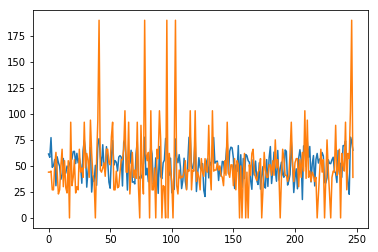

In [157]:
#Linear REGRESSOR 
reg = LinearRegression(normalize =True)

x_train, x_test, y_train, y_test = train_test_split(features, pm, test_size =0.2, random_state =42)
reg.fit(x_train, y_train)

pred = reg.predict(x_test)

plt.plot(pred)
plt.plot(y_test)
print(mean_squared_error(pred, y_test)**0.5)
print(mean_absolute_error(pred, y_test))




In [0]:
learning_curve(reg, features, pm)

In [0]:
pred = np.reshape(pred, (248,1))
y_test = np.reshape(y_test, (248,1))
result = np.hstack((pred, y_test))
print(result)


In [151]:
print(max(np.diff(result)))
print(min(np.diff(result)))

[116.96466235]
[-76.39307841]


29.021317472539792
22.114975787170735


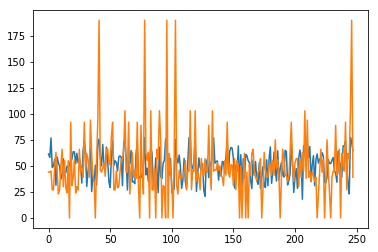

In [167]:
reg = SGDRegressor(penalty = 'elasticnet', warm_start=True)

reg.fit(x_train,y_train)

pred = reg.predict(x_test)

plt.plot(pred)
plt.plot(y_test)

print(mean_squared_error(pred, y_test)**0.5)
print(mean_absolute_error(pred, y_test))

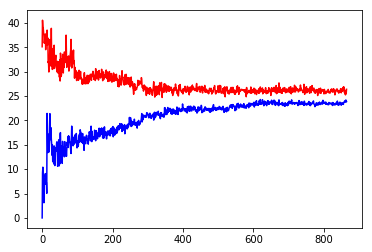

In [169]:
learning_curve(reg, features, pm)

In [170]:
pred = np.reshape(pred, (248,1))
y_test = np.reshape(y_test, (248,1))
result = np.hstack((pred, y_test))
print(result)

[[ 40.673972    44.        ]
 [ 40.673972    44.        ]
 [131.73841141  45.        ]
 [ 36.29111704  27.        ]
 [ 36.29111704  27.        ]
 [ 41.65470193  50.        ]
 [ 38.38328677  63.        ]
 [ 37.11578362  44.        ]
 [ 36.29111704  23.        ]
 [ 36.29111704  27.        ]
 [ 36.29111704  50.        ]
 [ 41.27246138  66.        ]
 [ 36.29111704  30.        ]
 [ 42.28984964  55.        ]
 [ 42.28984964  29.        ]
 [ 34.76797711  24.        ]
 [ 42.28752513  55.        ]
 [ 37.06171501   0.        ]
 [ 63.60069586  92.        ]
 [ 37.67075064  31.        ]
 [ 35.27540077  39.        ]
 [ 56.92716106  56.        ]
 [ 36.29111704  24.        ]
 [ 33.61955271  30.        ]
 [ 36.67566087  27.        ]
 [ 69.68989381  66.        ]
 [ 37.06171501  44.        ]
 [ 32.83073858  48.        ]
 [ 35.15252094  39.        ]
 [ 79.99970943  92.        ]
 [ 39.72346228  48.        ]
 [ 40.41897954  62.        ]
 [ 41.58125783  55.        ]
 [ 36.29111704  39.        ]
 [ 97.112606  

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


23.74126122160708
16.35693798210527


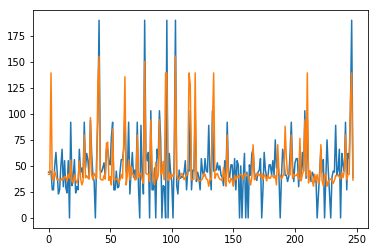

In [171]:
reg = RandomForestRegressor(max_depth=4)
reg.fit(x_train, y_train)
pred = reg.predict(x_test)


plt.plot(y_test)
plt.plot(pred)
print(mean_squared_error(pred, y_test)**0.5)
print(mean_absolute_error(pred, y_test))

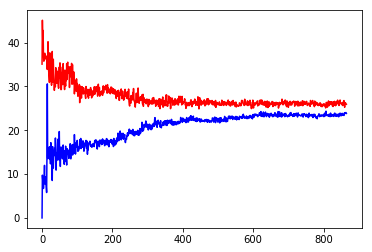

In [172]:
learning_curve(reg, features, pm)